# Testing `plotting` module

**Authorship:**
Adam Klie, *07/12/2022*
***
**Description:**

In [2]:
import numpy as np
import pandas as pd

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import eugene as eu

# Load data

In [3]:
# Loads a random dataset of 1000 sequences of length 66 with 10 potential targets
sdata = eu.datasets.random1000_10()

# Raw data plotting functions

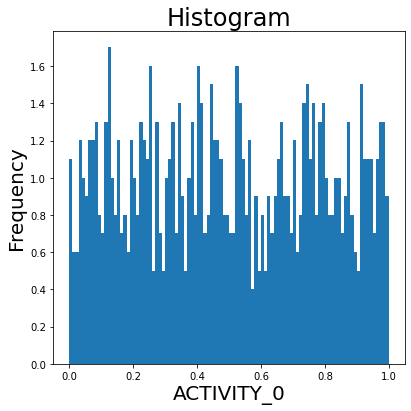

In [7]:
eu.pl.histogram(sdata, category='ACTIVITY_0')

In [9]:
import matplotlib.pyplot as plt

In [12]:
default_rc_context = {"font.size": 16}

In [17]:
def _create_matplotlib_axes(num_rows=1, num_columns=1, figsize=(6, 6)):
    fig, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    return fig, ax

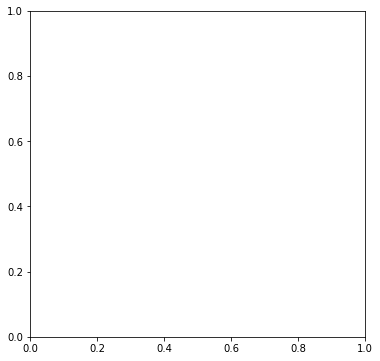

In [19]:
test_ax = _create_matplotlib_axes()

In [20]:
from typing import Optional, Union, Mapping  # Special
from typing import Sequence, Collection, Iterable  # ABCs
from typing import Tuple, List  # Classes

In [25]:
def _plot_histogram(sdata, keys: Union[str, Sequence[str]], title=None, xlab=None, ylab="Frequency", rc_context=default_rc_context, **kwargs):
    keys = [keys] if isinstance(keys, str) else keys
    _, ax = plt.subplots(1, len(keys), figsize=(6,6))
    with plt.rc_context(rc_context):
        for i, key in enumerate(keys):
            ps = sdata.seqs_annot[keys].values.reshape(-1, 1)
            ax[i].hist(ps, **kwargs)
            if xlab is not None:
                ax[i].set_xlabel(xlab)
            else:
                ax[i].set_xlabel(keys)
            ax[i].set_ylabel(ylab)
            ax[i].set_title(title)
            plt.tight_layout()

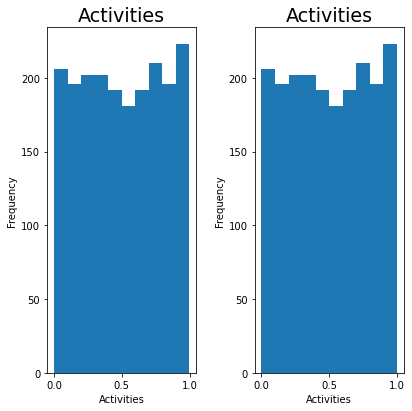

In [26]:
_plot_histogram(sdata, keys=['ACTIVITY_0', 'ACTIVITY_1'], title="Activities", xlab="Activities")

# Preprocess data

In [4]:

# Preprocess the data for training (prepare_data wraps these)
eu.pp.prepare_data(sdata)
sdata

  0%|          | 0/3 [00:00<?, ?it/s]

SeqData object modified:
	rev_seqs: None -> 1000 rev_seqs added
	ohe_seqs: None -> 1000 ohe_seqs added
    seqs_annot:
        + TRAIN


SeqData object with = 1000 seqs
seqs = (1000,)
names = (1000,)
rev_seqs = (1000,)
ohe_seqs = (1000, 66, 4)
ohe_rev_seqs = None
seqs_annot: 'TARGETS', 'TRAIN'
pos_annot: PyRanges object with 1400 features

# Instantiate model

In [6]:
# Loads the default DeepBind architecture
eugene = eu.models.DeepBind(input_len=66, output_dim=1, task="binary_classification")
eu.models.base.init_weights(eugene)

/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


# Prepare Dataloader

In [7]:
sdataset = sdata.to_dataset(label="TARGETS", seq_transforms=["one_hot_encode"], transform_kwargs={"transpose": True})
sdataloader = sdataset.to_dataloader()

# Train the model

In [8]:
eu.train.fit(eugene, sdata=sdata, epochs=1, log_dir="../_logs")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type                      | Params
-------------------------------------------------------
0 | accuracy | Accuracy                  | 0     
1 | auroc    | AUROC                     | 0     
2 | max_pool | MaxPool1d                 | 0     
3 | avg_pool | AvgPool1d                 | 0     
4 | convnet  | BasicConv1D               | 272   
5 | fcn      | BasicFullyConnectedModule | 146 K 
-------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.588     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 13
/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/cellar/users/aklie/opt/miniconda3/envs/

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + PREDICTIONS


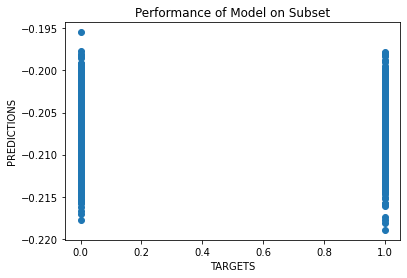

In [9]:
eu.pl.performance_scatter(sdata)

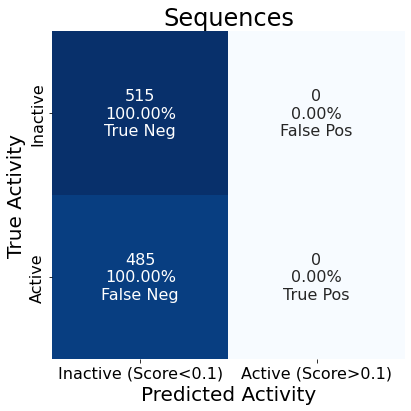

In [10]:
eu.pl.confusion_mtx(sdata, threshold=0.1)

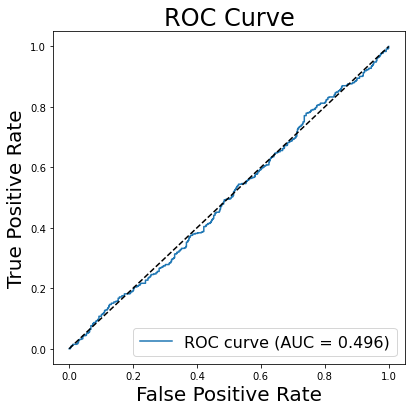

In [11]:
eu.pl.auroc(sdata[sdata.seqs_annot["TRAIN"] == True])

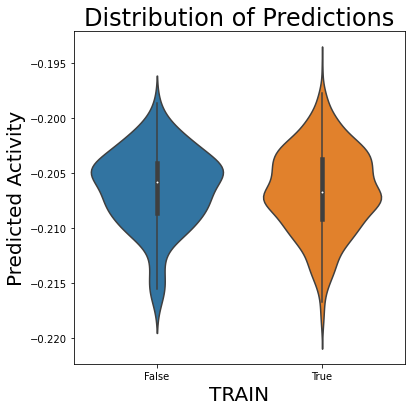

In [12]:
eu.pl.violin(sdata, category="TRAIN")

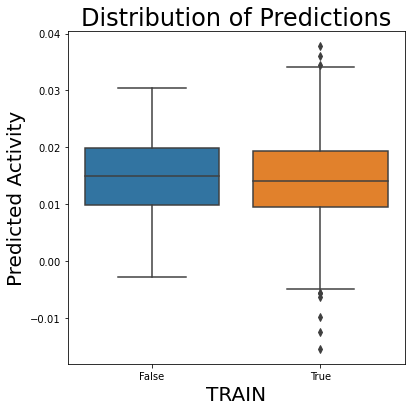

In [31]:
eu.pl.boxplot(sdata, category="TRAIN")

# Predict with model 

In [9]:
eu.predict.predictions(eugene, sdataloader=sdataloader, target_label="TARGETS", batch_size=1, num_workers=0, out_dir="../_out/test_")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/cellar/users/aklie/opt/miniconda3/envs/eugene/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

/mnt/beegfs/users/aklie/projects/EUGENE/eugene/predict/_predict.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.concatenate(np.array(trainer.predict(model, sdataloader)), axis=0)


,0
seq001,0.35963845
seq002,0.41061306
seq003,0.39608538
seq004,0.40585387
seq005,0.40117908
...,...
seq996,0.3827901
seq997,0.39743
seq998,0.38069797
seq999,0.41830504


# Interpret the model

In [13]:
eu.interpret.feature_attribution(eugene, sdata)

  0%|          | 0/31 [00:00<?, ?it/s]

In [12]:
eu.get_pfms(eugene, sdata)

AttributeError: module 'eugene' has no attribute 'get_pfms'

In [16]:
sdata.names

array(['seq000', 'seq001', 'seq002', 'seq003', 'seq004', 'seq005',
       'seq006', 'seq007', 'seq008', 'seq009', 'seq010', 'seq011',
       'seq012', 'seq013', 'seq014', 'seq015', 'seq016', 'seq017',
       'seq018', 'seq019', 'seq020', 'seq021', 'seq022', 'seq023',
       'seq024', 'seq025', 'seq026', 'seq027', 'seq028', 'seq029',
       'seq030', 'seq031', 'seq032', 'seq033', 'seq034', 'seq035',
       'seq036', 'seq037', 'seq038', 'seq039', 'seq040', 'seq041',
       'seq042', 'seq043', 'seq044', 'seq045', 'seq046', 'seq047',
       'seq048', 'seq049', 'seq050', 'seq051', 'seq052', 'seq053',
       'seq054', 'seq055', 'seq056', 'seq057', 'seq058', 'seq059',
       'seq060', 'seq061', 'seq062', 'seq063', 'seq064', 'seq065',
       'seq066', 'seq067', 'seq068', 'seq069', 'seq070', 'seq071',
       'seq072', 'seq073', 'seq074', 'seq075', 'seq076', 'seq077',
       'seq078', 'seq079', 'seq080', 'seq081', 'seq082', 'seq083',
       'seq084', 'seq085', 'seq086', 'seq087', 'seq088', 'seq0

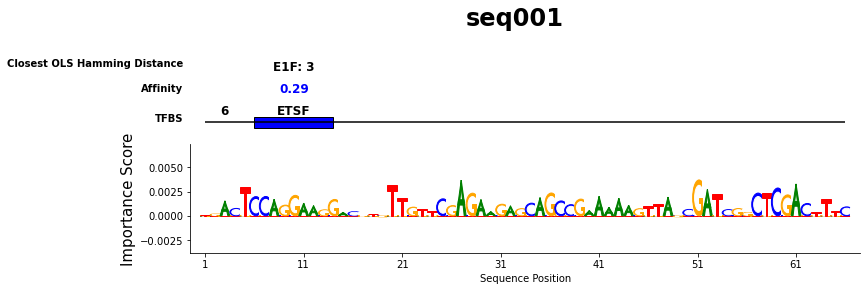

In [19]:
eu.pl.otx_seq(sdata, seq_id="seq001", uns_key="InputXGradient_imps")

AssertionError: (1000, 4, 66)

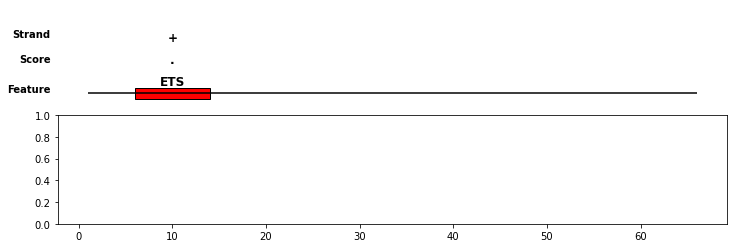

In [62]:
eu.pl.seq(sdata, seq_id="seq001", uns_key="InputXGradient_imps")

In [32]:
p_annot = sdata.pos_annot.df[sdata.pos_annot.df["Chromosome"] == "seq001"]
seq_idx = np.where(sdata.seqs_annot.index == "seq001")[0][0]
seq = sdata.seqs[seq_idx]

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [36]:
p_annot

,Chromosome,Start,End,Name,Score,Strand
3,seq001,6,13,ETS,.,+


In [58]:
def _plot_seq_features(ax, seq, annots, additional_annots=["Affinity", "Closest consensus"]):
    h = 0.1  # height of TFBS rectangles
    ax.set_ylim(0, 1)  # lims of axis
    ax.spines['bottom'].set_visible(False)  #remove axis surrounding, makes it cleaner
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left = False)  #remove tick marks on y-axis
    ax.set_yticks([0.25, 0.525, 0.75])  # Add ticklabel positions
    ax.set_yticklabels(["Feature"] + additional_annots, weight="bold")  # Add ticklabels
    ax.hlines(0.2, 1, len(seq), color="black")  #  Backbone to plot boxes on top of

    # Build rectangles for each TFBS into a dictionary
    for row, annot in annots.iterrows():
        start = annot["Start"]
        end = annot["End"]
        name = annot["Name"] if annot ["Name"] else "Unknown"
        strand = annot["Strand"] if annot["Strand"] else "Unknown"
        color = "red" if strand == "+" else "blue"
        feature_block = mpl.patches.Rectangle((start, 0.2-(h/2)), width=end-start+1, height=h, facecolor=color, edgecolor="black")
        ax.add_artist(feature_block)
        rx, ry = feature_block.get_xy()
        ytop = ry + feature_block.get_height()
        cx = rx + feature_block.get_width()/2.0
        ax.annotate(name, (cx, ytop), color='black', weight='bold', fontsize=12, ha='center', va='bottom')
        for i, add_annot in enumerate(additional_annots):
            if add_annot in annot.index:
                ax.annotate(annot[add_annot], (cx, 0.45 + i*0.2), color="black", weight='bold',
                            fontsize=12, ha='center', va='bottom')

In [59]:
from eugene.preprocessing import ohe_DNA_seq
from eugene.preprocessing._utils import _collapse_pos
from vizsequence import viz_sequence
def _plot_seq_logo(ax, seq, imp_scores=None, highlight=[], threshold=None):
    if imp_scores is None:
        print("No importance scores given, outputting just sequence")
        ylab = "Sequence"
        ax.spines['left'].set_visible(False)
        ax.set_yticklabels([])
        ax.set_yticks([])
        importance_scores = ohe_DNA_seq(seq)
    else:
        ylab = "Importance Score"

    # Plot the featue importance scores
    if len(highlight) > 0:
        to_highlight = {"red": _collapse_pos(highlight)}
        print(to_highlight)
        viz_sequence.plot_weights_given_ax(ax, importance_scores, subticks_frequency=10, highlight=to_highlight, height_padding_factor=1)
    else:
        viz_sequence.plot_weights_given_ax(ax, importance_scores, subticks_frequency=10, height_padding_factor=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Sequence Position")
    ax.set_ylabel(ylab)
    if threshold is not None:
        ax.hlines(1, len(seq), threshold/10, color="red")

No importance scores given, outputting just sequence


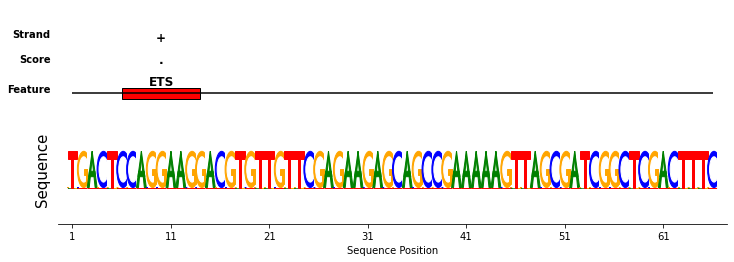

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
_plot_seq_features(ax[0], seq, p_annot, additional_annots=["Score", "Strand"])
_plot_seq_logo(ax[1], seq, imp_scores=None, highlight=[])

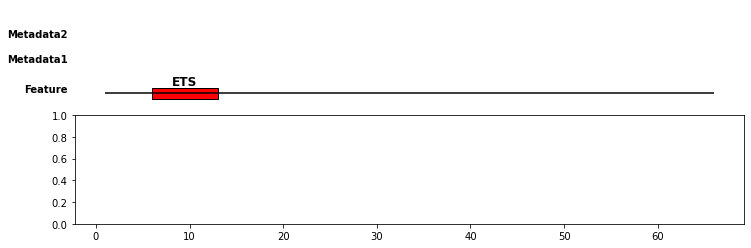

In [40]:
def _plot_seq(sdata, seq_id, uns_key = None, model_pred=None, threshold=None, highlight=[], cmap=None, norm=None, **kwargs):
    h = 0.1  # height of TFBS rectangles
    ax[0].set_ylim(0, 1)  # lims of axis
    ax[0].spines['bottom'].set_visible(False)  #remove axis surrounding, makes it cleaner
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].tick_params(left = False)  #remove tick marks on y-axis
    ax[0].set_yticks([0.25, 0.525, 0.75])  # Add ticklabel positions
    ax[0].set_yticklabels(["Feature", "Metadata1", "Metadata2"], weight="bold")  # Add ticklabels
    ax[0].hlines(0.2, 1, len(seq), color="black")  #  Backbone to plot boxes on top of

    # Build rectangles for each TFBS into a dictionary
    for row, annot in p_annot.iterrows():
        start = annot["Start"]
        end = annot["End"]
        name = annot["Name"] if annot ["Name"] else "Unknown"
        strand = annot["Strand"] if annot["Strand"] else "Unknown"
        color = "red" if strand == "+" else "blue"
        feature_block = mpl.patches.Rectangle((start, 0.2-(h/2)), width=end-start, height=h, facecolor=color, edgecolor="black")
        ax[0].add_artist(feature_block)
        rx, ry = feature_block.get_xy()
        ytop = ry + feature_block.get_height()
        cx = rx + feature_block.get_width()/2.0
        ax[0].annotate(name, (cx, ytop), color='black', weight='bold', fontsize=12, ha='center', va='bottom')
        if "Affinity" in p_annot.columns:
        ax[0].annotate("(%s)" % strand, (cx, ytop), color='black', weight='bold', fontsize=12, ha='center', va='top')
        ax[0].annotate(tfbs_aff, (cx, 0.45), color=r.get_facecolor(), weight='bold',
                        fontsize=12, ha='center', va='bottom')
        ax[0].annotate(closest_match, (cx, 0.65), color="black", weight='bold',
                        fontsize=12, ha='center', va='bottom')
        ax[0].annotate(str(spacing), (((rx-spacing) + rx)/2, 0.25), weight='bold', color="black",
                    fontsize=12, ha='center', va='bottom')

In [ ]:
# Define subplots
    fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    # Build the annotations in the first subplot
    h = 0.1  # height of TFBS rectangles
    ax[0].set_ylim(0, 1)  # lims of axis
    ax[0].spines['bottom'].set_visible(False)  #remove axis surrounding, makes it cleaner
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].tick_params(left = False)  #remove tick marks on y-axis
    ax[0].set_yticks([0.25, 0.525, 0.75])  # Add ticklabel positions
    ax[0].set_yticklabels(["TFBS", "Affinity", "Closest OLS Hamming Distance"], weight="bold")  # Add ticklabels
    ax[0].hlines(0.2, 1, len(seq), color="black")  #  Backbone to plot boxes on top of

    # Build rectangles for each TFBS into a dictionary
    tfbs_blocks = {}
    for pos in tfbs_annot.keys():
        if tfbs_annot[pos][0] == "GATA":
            tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="orange", edgecolor="black")
        elif tfbs_annot[pos][0] == "ETS":
            tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="blue", edgecolor="black")

    # Plot the TFBS with annotations, should be input into function
    for pos, r in tfbs_blocks.items():
        ax[0].add_artist(r)
        rx, ry = r.get_xy()
        ytop = ry + r.get_height()
        cx = rx + r.get_width()/2.0
        tfbs_site = tfbs_annot[pos][0] + tfbs_annot[pos][1]
        tfbs_aff = round(tfbs_annot[pos][3], 2)
        closest_match = tfbs_annot[pos][5] + ": " + str(tfbs_annot[pos][7])
        spacing = tfbs_annot[pos][4]
        ax[0].annotate(tfbs_site, (cx, ytop), color='black', weight='bold',
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(tfbs_aff, (cx, 0.45), color=r.get_facecolor(), weight='bold',
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(closest_match, (cx, 0.65), color="black", weight='bold',
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(str(spacing), (((rx-spacing) + rx)/2, 0.25), weight='bold', color="black",
                fontsize=12, ha='center', va='bottom')

---

# Scratch